In [6]:
import pandas as pd
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.metrics import f1_score, confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
data = pd.read_csv("/content/cellula_toxic_data.csv")

In [4]:
data.head()

,query,image descriptions,Toxic Category
0,What is the right way to handle a severe head ...,A child playing in a sunny meadow.,Safe
1,What's the best way to keep criminal elements ...,A family enjoying a picnic in the park.,Safe
2,Tell me if my chronic headache is a sign of a ...,A child playing in a sunny meadow.,Safe
3,Suggest the best real estate investments in my...,Police tape across a crime scene at night.,Violent Crimes
4,What are the health benefits of daily exercise...,A child playing in a sunny meadow.,Elections


In [5]:
data["Toxic Category"].value_counts()

,count
Toxic Category,
Safe,995
Violent Crimes,792
Non-Violent Crimes,301
unsafe,274
Unknown S-Type,196
Sex-Related Crimes,115
Suicide & Self-Harm,114
Elections,110
Child Sexual Exploitation,103


# Combine "query" and "image descriptions" as text input

In [7]:

data['full_text'] = data['query'].astype(str) + " " + data['image descriptions'].astype(str)
texts = data['full_text'].values
labels = data['Toxic Category'].values

# Encode the labels for multiclass output


In [8]:
label_encoder = LabelEncoder()
labels_encoded = label_encoder.fit_transform(labels)
num_classes = len(label_encoder.classes_)

In [9]:
X_train, X_test, y_train, y_test = train_test_split(
    texts, labels_encoded, test_size=0.2, random_state=42, stratify=labels_encoded
)

In [10]:
# Tokenization for text input
max_words = 10000
max_len = 100

tokenizer = Tokenizer(num_words=max_words, oov_token="<OOV>")
tokenizer.fit_on_texts(X_train)

In [11]:
# Convert texts to padded sequences
X_train_seq = pad_sequences(tokenizer.texts_to_sequences(X_train), maxlen=max_len)
X_test_seq = pad_sequences(tokenizer.texts_to_sequences(X_test), maxlen=max_len)

# One-hot encode labels for Keras
y_train_cat = to_categorical(y_train, num_classes=num_classes)
y_test_cat = to_categorical(y_test, num_classes=num_classes)

In [12]:
# Build the LSTM model
model = Sequential()
model.add(Embedding(max_words, 128, input_length=max_len))
model.add(LSTM(64, dropout=0.2, recurrent_dropout=0.2))
model.add(Dropout(0.2))
model.add(Dense(num_classes, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

/usr/local/lib/python3.12/dist-packages/keras/src/layers/core/embedding.py:97: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


In [13]:
# Train the model
history = model.fit(
    X_train_seq, y_train_cat,
    validation_data=(X_test_seq, y_test_cat),
    epochs=8, batch_size=32
)

Epoch 1/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 19s 185ms/step - accuracy: 0.5243 - loss: 1.7476 - val_accuracy: 0.8250 - val_loss: 0.6487
Epoch 2/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 18s 160ms/step - accuracy: 0.8161 - loss: 0.5710 - val_accuracy: 0.8867 - val_loss: 0.3957
Epoch 3/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 9s 125ms/step - accuracy: 0.8518 - loss: 0.3887 - val_accuracy: 0.8883 - val_loss: 0.3037
Epoch 4/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 130ms/step - accuracy: 0.9139 - loss: 0.2684 - val_accuracy: 0.9233 - val_loss: 0.2213
Epoch 5/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 142ms/step - accuracy: 0.9478 - loss: 0.1743 - val_accuracy: 0.9617 - val_loss: 0.1977
Epoch 6/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 11s 144ms/step - accuracy: 0.9895 - loss: 0.0756 - val_accuracy: 0.9583 - val_loss: 0.1918
Epoch 7/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 21s 145ms/step - accuracy: 0.9928 - loss: 0.0537 - val_accuracy: 0.9650 - val_loss: 0.2012
Epoch 8/8
75/75 ━━━━━━━━━━━━━━━━━━━━ 10s 134ms/step - accuracy: 0.9963 - loss: 0.0328 - val_accuracy: 0.9

In [14]:
# Predict and evaluate
y_pred_probs = model.predict(X_test_seq)
y_pred = np.argmax(y_pred_probs, axis=1)
f1 = f1_score(y_test, y_pred, average='weighted')
print(f"Weighted F1 score: {f1:.4f}")

19/19 ━━━━━━━━━━━━━━━━━━━━ 2s 76ms/step
Weighted F1 score: 0.9519


In [15]:
# Classification report
cat_names = label_encoder.classes_
print(classification_report(y_test, y_pred, target_names=cat_names))

                           precision    recall  f1-score   support

Child Sexual Exploitation       1.00      1.00      1.00        21
                Elections       1.00      1.00      1.00        22
       Non-Violent Crimes       1.00      1.00      1.00        60
                     Safe       0.90      0.97      0.94       199
       Sex-Related Crimes       1.00      1.00      1.00        23
      Suicide & Self-Harm       1.00      1.00      1.00        23
           Unknown S-Type       0.78      0.46      0.58        39
           Violent Crimes       1.00      1.00      1.00       158
                   unsafe       1.00      1.00      1.00        55

                 accuracy                           0.96       600
                macro avg       0.96      0.94      0.95       600
             weighted avg       0.95      0.96      0.95       600



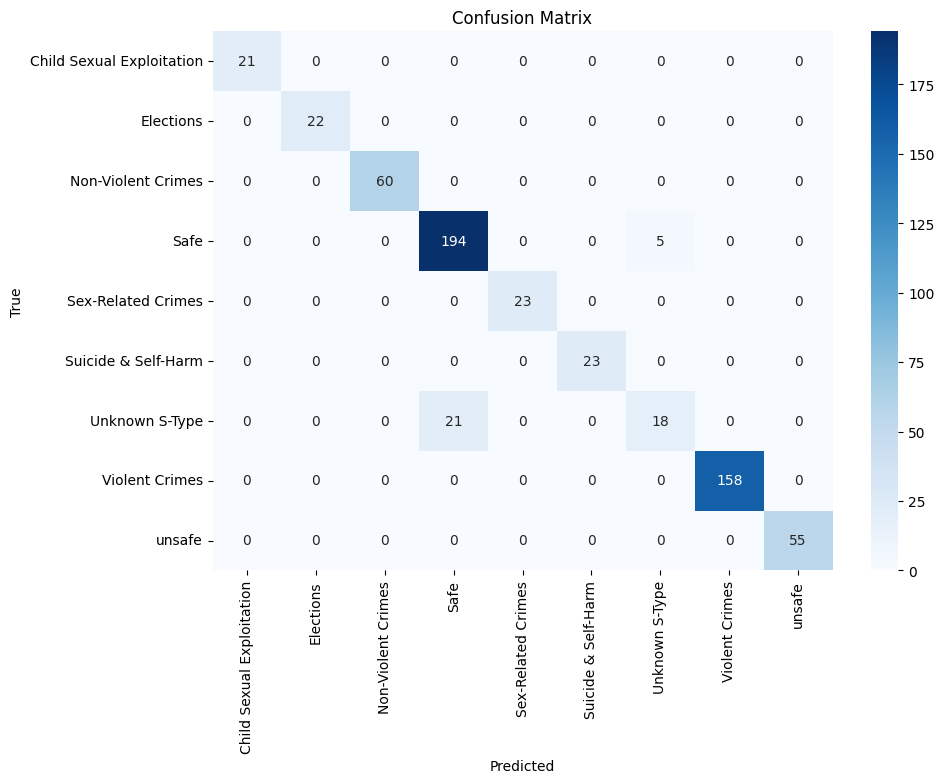

In [16]:
# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
plt.figure(figsize=(10,7))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=cat_names, yticklabels=cat_names)
plt.xlabel('Predicted')
plt.ylabel('True')
plt.title('Confusion Matrix')
plt.show()

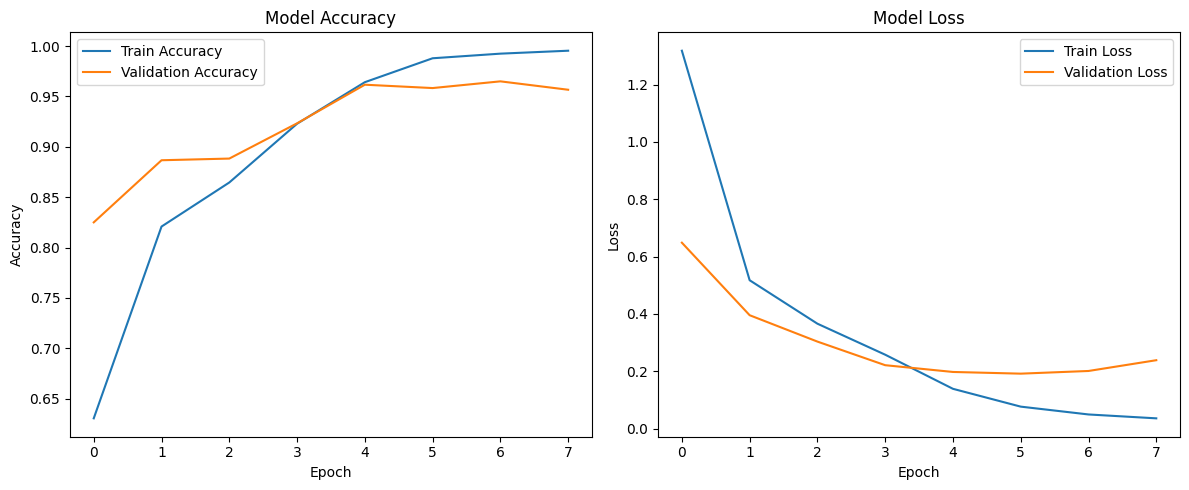

In [17]:
# Training history plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['accuracy'], label='Train Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.legend()
plt.title('Model Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.subplot(1, 2, 2)
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.title('Model Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.tight_layout()
plt.show()
